# &emsp;&emsp;**VIOLENCE DETECTION IN CROWD USING YOLOv8 AND MobileNetv2**
###### **Module title:** AI GROUP PROJECT MODEL  
###### **Module Code:** UFCEM1-60-M 
###### **Group 5** 
Student Name                | Student Number     | .
----------------------------|--------------------|-------------------
Chijioke Nwaiwu             | &emsp;22052026                   | 
Benjamin Adegbaju          | &emsp;22058114     |

In this project, we will be training a machine learning model that can detect weapons and violent actions in a crowded setting using YOLOv8 for object detection and MobileNetv2 for image classification.

# **IMPORT DEPENDENCIES**

In [3]:
# !pip install ultralytics

In [4]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import random
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode

tf.random.set_seed(73)

In [5]:
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# **LOAD THE DATASET**

In this section we load the dataset. The [dataset](https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset) was gotten from this [research paper](https://ieeexplore.ieee.org/abstract/document/9014714/citations?tabFilter=papers#citations). The dataset contains 2,000 videos divided into 2 subfolder namely 'Violence' and 'NonViolence'. Each subfolder contains 1,000 videos respectively with an average length of 5 seconds. Because of memory constraint using google colab, we would be working with a subset of the dataset which will contain 400 videos for both the 'violence' and 'non-violence', with each category having 200 videos each.

In [6]:
# Check if the violence and non-violence folder exists
if not os.path.exists('Violence'):
  print("The violence folder is missing, upload and try again")
elif not os.path.exists('NonViolence'):
  print("The non-violence folder is missing, upload and try again")
else:
  print("Dataset has been loaded")

Dataset has been loaded


In [7]:
# Assign the list of videos from the violence and non_violence folder to a variable
Violence_videos_list = os.listdir('Violence')
NonViolence_videos_list = os.listdir('NonViolence')

# **Data Visualization**

In [8]:
def view_dataset_sample(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [9]:
# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_videos_list)
Random_Violence_Video = random.choice(Violence_videos_list)

In [10]:
view_dataset_sample('/content/Violence/' + Random_Violence_Video)

In [11]:
view_dataset_sample('/content/NonViolence/' + Random_NonViolence_Video)

# **Frame Extraction**

In this section, we extract frames from the videos and resize the frames to a uniformed width and height before feeding it to the model for training.

In [12]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16
 
DATASET_DIR = "/content/"

# list the classes of videos 
CLASSES = ['Violence', 'NonViolence']

In [13]:
def video_to_frames(video_path):
 
    frames_list = []

    # Check if the video file can be opened.
    try:
        # Read the Video File
        video_reader = cv2.VideoCapture(video_path)
    except FileNotFoundError:
        print("The video file could not be found.")
        return None
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        if not success:
            break

      
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Convert the image to grayscale.
        grayscale_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

        # Normalize the resized frame
        normalized_frame = grayscale_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    video_reader.release()

    # Close all of the windows that are created when the video frames are displayed.
    cv2.destroyAllWindows()
 
    return frames_list

# **Dataset Creation**

In [14]:
def create_dataset():
 
    extracted_frames = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES):
        
        print(f'Extracting Data from the {class_name} Class')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = video_to_frames(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                extracted_frames.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    extracted_frames = np.asarray(extracted_frames)
    labels = np.array(labels)  

    return extracted_frames, labels, video_files_paths

In [15]:
# Create the dataset.
extracted_frames, labels, video_files_paths = create_dataset()

Extracting Data from the Violence Class
Extracting Data from the NonViolence Class


In [16]:
# function that previews 12 samples from the dataset frames 
def preview_dataset():
    simp = []
    label = []
    n = 12
    outer_image = range(len(extracted_frames))

    inner_image = range(len(extracted_frames[0]))

    random_frames = random.sample(outer_image, n)
    rand = random.sample(inner_image, n)

    for i in range(len(random_frames)):
      simp.append(extracted_frames[random_frames[i]][rand[i]])
      label.append(labels[random_frames[i]])

    plt.figure(figsize=(12, 12))
    plot_index = 0
    for image in random.sample(simp, 12):
        plot_index += 1
        # print(plot_index)
        plt.subplot(3, 4, plot_index)
        plt.axis('Off')
        plt.title('Label: %s' % CLASSES[label[(plot_index - 1)]])
        plt.imshow(image)

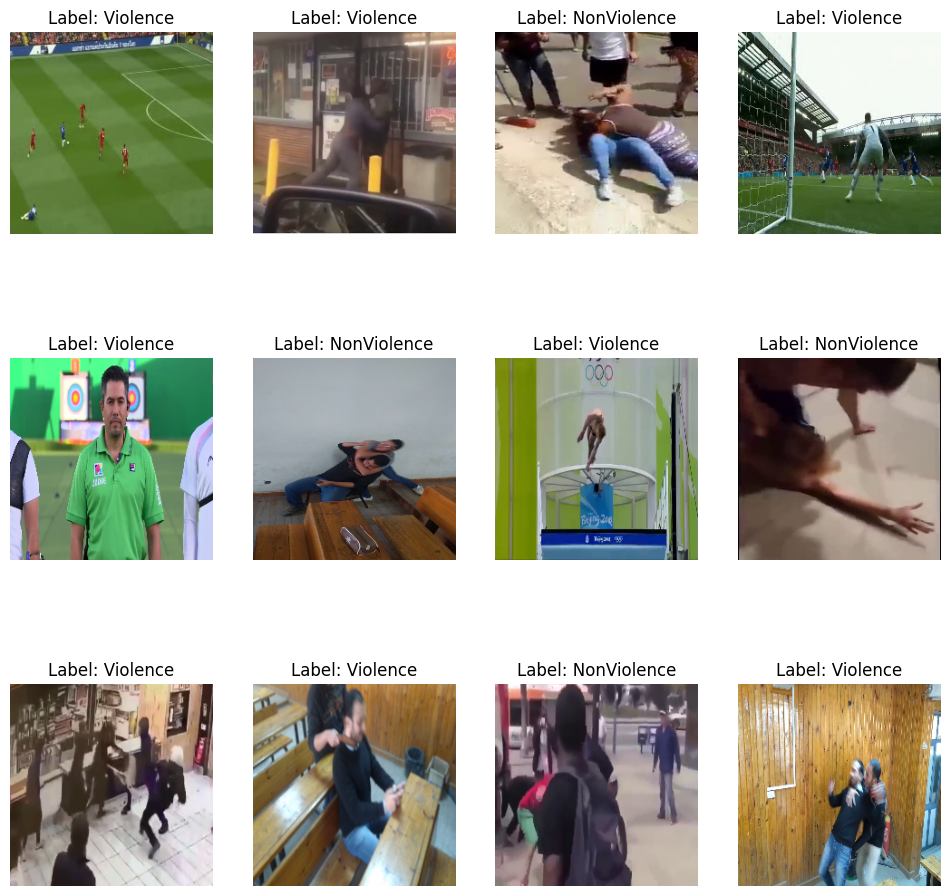

In [17]:
preview_dataset()

# **Encoding and Spliting the Dataset**

In [18]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [19]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
extracted_frames_train, extracted_frames_test, labels_train, labels_test = train_test_split(extracted_frames, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [20]:
print(extracted_frames_train.shape,labels_train.shape )
print(extracted_frames_test.shape, labels_test.shape)

(180, 16, 224, 224, 3) (180, 2)
(20, 16, 224, 224, 3) (20, 2)


#Model Training for Video Classification

In [21]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False, weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

#mobilenet.summary()

In [22]:
def create_model():
 
    model = Sequential()

    ########################################################################################################################
    
    #Specifying Input to match features shape
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES), activation = 'softmax'))
 
    ########################################################################################################################
 
    model.summary()
    
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 7, 7, 1280)   2257984   
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 16, 7, 7, 1280)    0         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 62720)        0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16064768  
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

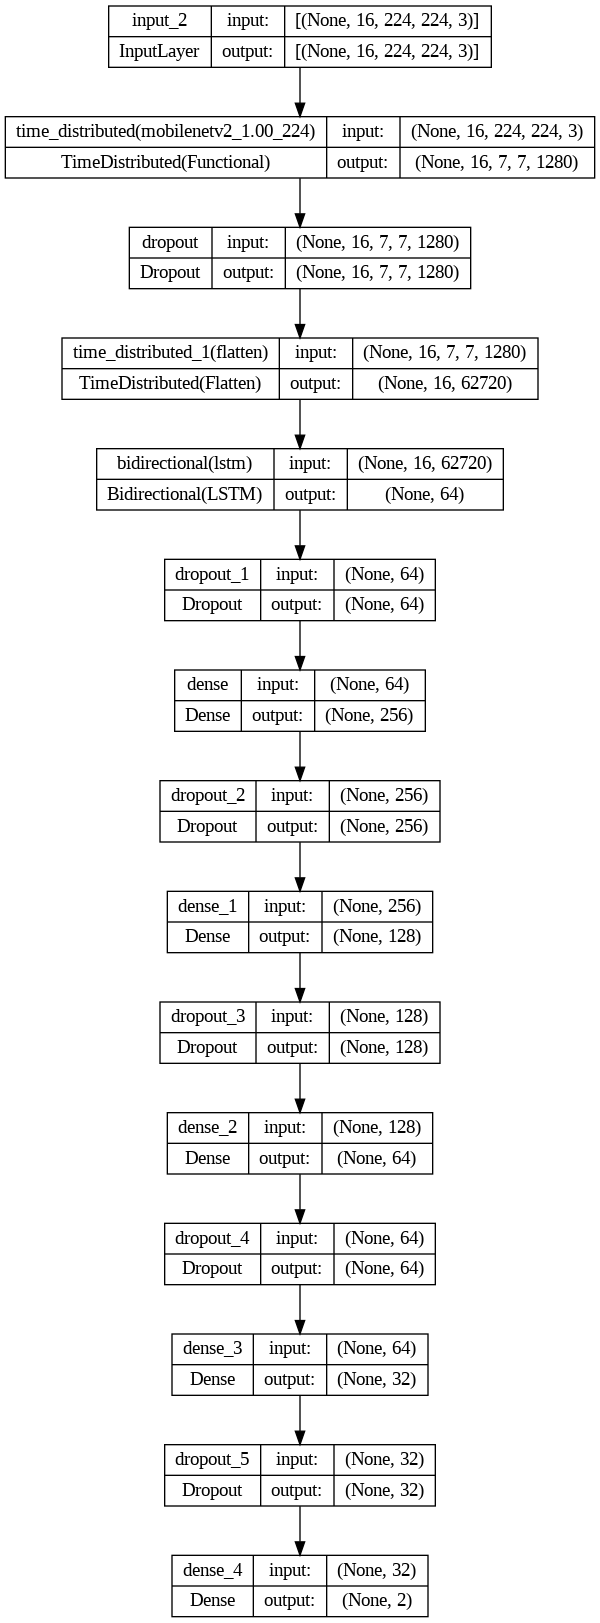

In [23]:
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Callbacks and Fittings

In [ ]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
# Compiling the model 
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
 
# Fitting the model 
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = extracted_frames_train, y = labels_train, epochs = 20, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/20
 1/18 [>.............................] - ETA: 7:27 - loss: 0.6770 - accuracy: 0.5000

In [ ]:
model_evaluation_history = MoBiLSTM_model.evaluate(extracted_frames_test, labels_test)

#Model Evaluation

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

In [ ]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

#Model Prediction

In [ ]:
labels_predict = MoBiLSTM_model.predict(extracted_frames_test)

In [ ]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [ ]:
labels_test_normal.shape , labels_predict.shape

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Confusion Matrix

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

Classification Report

In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)